## 🩺 👩🏼‍⚕️ 👨🏼‍⚕️ Machine learning classifiers for predicting no-show appointments 👩🏼‍💼 👨🏼‍💼

This is a notebook to test different classifiers on the dataset from Kaggle (noshowappointments). The goal is to predict whether a patient will show up for an appointment or not.
The notebook goal is to create the best classifier possible, and to compare the results of different classifiers. Also, explainable methods are employed to understand the results of the classifiers as the classifiers are used in a medical context. The classifiers developed are not explained by their structure.

The classifiers are tested on the dataset from Kaggle (noshowappointments). The dataset contains information about 110527 medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row. The dataset is available at https://www.kaggle.com/joniarroba/noshowappointments.

The dataset has been cleaned and preprocessed in the notebook "eda-prep.ipynb". The cleaned dataset is saved in the file "cleaned_data.csv".

***

The following models are trained and tested:

1. XGBoost

XGBoost stands for eXtreme Gradient Boosting. 
XGBoost is an implementation of gradient boosted trees designed for speed and performance that is dominative competitive machine learning.

https://xgboost.readthedocs.io/en/latest/

2. Random Forest

Random Forest is an ensemble learning method, in this notebook it is used as a classifier. 
The method is based on decision trees and is based on the idea that a large number of relatively uncorrelated models (trees) operating as a committee will outperform any of the individual constituent models.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

3. Gradient Boosting

Gradient Boosting is an ensemble learning approach which produces an additive model in a forward stage-wise fashion.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

4. AdaBoost

> AdaBoost classfier is a meta-estimator that begins by fitting a classifier on the > original dataset and then fits additional copies of the classifier on the same dataset > but where the weights of incorrectly classified instances are adjusted such that > subsequent classifiers focus more on difficult cases.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

***

The following methods are used to explain the results of the classifiers:
- Feature importance

Feature importance is derived from the feature_importances_ attribute of the classifier when fitted.

- PDPs (Partial Dependence Plots)

> The partial dependence plot (short PDP or PD plot) shows the marginal effect one or > two features have on the predicted outcome of a machine learning model (J. H. > Friedman 2001).

- ICE (Individual Conditional Expectation)

> The ICE plot shows the dependence between the target function and a feature of interest. ICE plots visualize the dependence of the prediction on a feature fo each sample separately with one line per sample. 

https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#partial-dependence-and-individual-conditional-expectation-plots

- LIME

The LIME method is used to explain the predictions of the model.
It approximates the model locally within a small region around the instance to be explained. 
The new model is trained based on perturbated training data.
For numerical features, the perturbated data means from given data environment and predicion of its classification based on black-box model.
On this trening data, the interpretable model is trained.
The interpretability feature is used of the trained model in order to analyze the impact of parameters on the classification.

https://github.com/marcotcr/lime

https://arxiv.org/pdf/1602.04938.pdf

- SHAP (SHapley Additive exPlanations)

For each parameter, the Shapley value is calculated through building coalitions of parameters and calculating the impact of the parameter on the classification.

https://github.com/slundberg/shap

http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf

***

### 🗃 Import libraries

In [2]:
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

from sklearn.inspection import PartialDependenceDisplay, partial_dependence

from imblearn.under_sampling import InstanceHardnessThreshold

from interpret.blackbox import LimeTabular
from interpret import show
import shap

from yellowbrick.model_selection import FeatureImportances

import wandb

In [ ]:
!git clone https://github.com/SauceCat/PDPbox.git
%cd PDPbox
!python setup.py install

In [3]:
import pdpbox
from pdpbox import pdp

### 🗂 Prepare data (data split, deal with imbalanced data)

In [4]:
df = pd.read_csv('data/cleaned_data_2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110521 entries, 0 to 110520
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   Gender                110521 non-null  int64
 1   Scholarship           110521 non-null  int64
 2   Hypertension          110521 non-null  int64
 3   Diabetes              110521 non-null  int64
 4   Alcoholism            110521 non-null  int64
 5   Handicap              110521 non-null  int64
 6   SMS_received          110521 non-null  int64
 7   Show                  110521 non-null  int64
 8   ScheduledHour         110521 non-null  int64
 9   ScheduledMonth        110521 non-null  int64
 10  AppointmentMonth      110521 non-null  int64
 11  ScheduledDayOfWeek    110521 non-null  int64
 12  AppointmentDayOfWeek  110521 non-null  int64
 13  AgeGroupInt           110521 non-null  int64
 14  NeighbourhoodInt      110521 non-null  int64
 15  AwaitingTimeGroup     110521 non-n

In [5]:
X = df.drop(['Show'], axis=1)
y = df['Show']

In [6]:
print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({1: 88207, 0: 22314})


#### ⚖️ IHT for imbalanced data

This approach is inspired by the paper Batool, Tasneem, et al. "Predicting hospital no-shows using machine learning." 2020 IEEE International Conference on Internet of Things and Intelligence System (IoTaIS). IEEE, 2021.

In [7]:
iht = InstanceHardnessThreshold(random_state=42)
X_res, y_res = iht.fit_resample(X, y)

In [8]:
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 23282, 0: 22314})


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

In [10]:
print('X_train size: ', X_train.shape)
print('X_test size: ', X_test.shape)
print('y_train size: ', y_train.shape)
print('y_test size: ', y_test.shape)

X_train size:  (31917, 15)
X_test size:  (13679, 15)
y_train size:  (31917,)
y_test size:  (13679,)


In [11]:
print('y_train value counts: ', y_train.value_counts())
print('y_test value counts: ', y_test.value_counts())

y_train value counts:  1    16322
0    15595
Name: Show, dtype: int64
y_test value counts:  1    6960
0    6719
Name: Show, dtype: int64


###  📊 W&B for logging

In [46]:
WANDB_PROJECT_NAME = "mappshow-hp-optimize"

### ⚡️ XGBoost

#### Hyperparameter tuning

In [34]:
sweep_config_xgboost = {
    'name': 'XGBoost',
    'method': 'bayes',
    'metric': {
        'name': 'accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'n_estimators': {
            'distribution': 'int_uniform',
            'min': 100,
            'max': 1000
        },
        'learning_rate': {
            'distribution': 'uniform',
            'min': 0.01,
            'max': 0.5
        },
        'max_depth': {
            'distribution': 'int_uniform',
            'min': 3,
            'max': 10
        },
        'min_child_weight': {
            'distribution': 'int_uniform',
            'min': 1,
            'max': 10
        },
        'gamma': {
            'distribution': 'uniform',
            'min': 0,
            'max': 0.5
        }
    }
}


def train_xgboost():
    wandb.init(project=WANDB_PROJECT_NAME, config=wandb.config)

    config = wandb.config
    
    xgboost_cls = XGBClassifier(
        n_estimators=config.n_estimators,
        learning_rate=config.learning_rate,
        max_depth=config.max_depth,
        min_child_weight=config.min_child_weight,
        gamma=config.gamma,
        objective='binary:logistic',
        seed=27
    )

    xgboost_cls.fit(X_train, y_train)

    y_pred = xgboost_cls.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    wandb.log({'accuracy': accuracy, 'f1': f1})


In [35]:
sweep_id_xgboost = wandb.sweep(sweep_config_xgboost, project=WANDB_PROJECT_NAME)
wandb.agent(sweep_id_xgboost, train_xgboost, count=10)

Create sweep with ID: 1uq9nvkl
Sweep URL: https://wandb.ai/polejowska/mappshow-hp-optimize/sweeps/1uq9nvkl


wandb: Agent Starting Run: 9cb6pte5 with config:
wandb: 	gamma: 0.3104870355896093
wandb: 	learning_rate: 0.37939792806813755
wandb: 	max_depth: 7
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 405
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
accuracy,0.95723
f1,0.95712


wandb: Agent Starting Run: 0cz02r4r with config:
wandb: 	gamma: 0.2100508316516806
wandb: 	learning_rate: 0.2030395920120922
wandb: 	max_depth: 4
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 766
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
accuracy,0.94995
f1,0.94982


wandb: Agent Starting Run: go5xlftc with config:
wandb: 	gamma: 0.29542853966295685
wandb: 	learning_rate: 0.048444335203811355
wandb: 	max_depth: 9
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 171
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
accuracy,0.95023
f1,0.9501


wandb: Agent Starting Run: ipmy0zrw with config:
wandb: 	gamma: 0.3226488452522947
wandb: 	learning_rate: 0.4603886196875448
wandb: 	max_depth: 5
wandb: 	min_child_weight: 7
wandb: 	n_estimators: 484
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
accuracy,0.9543
f1,0.95418


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z1kx9936 with config:
wandb: 	gamma: 0.31577938040041226
wandb: 	learning_rate: 0.3334662293311713
wandb: 	max_depth: 7
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 418
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
accuracy,0.95709
f1,0.95698


wandb: Agent Starting Run: hcgv0paq with config:
wandb: 	gamma: 0.31429094417433723
wandb: 	learning_rate: 0.4189206961369724
wandb: 	max_depth: 9
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 400
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
accuracy,0.95687
f1,0.95677


wandb: Agent Starting Run: mlmagktk with config:
wandb: 	gamma: 0.4597961432614545
wandb: 	learning_rate: 0.42409007705547686
wandb: 	max_depth: 7
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 263
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
accuracy,0.95709
f1,0.95697


wandb: Agent Starting Run: jrg0ytt6 with config:
wandb: 	gamma: 0.2512475953703103
wandb: 	learning_rate: 0.38423970489611026
wandb: 	max_depth: 5
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 243
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
accuracy,0.95452
f1,0.95439


wandb: Agent Starting Run: vx45lkcy with config:
wandb: 	gamma: 0.3405650230423173
wandb: 	learning_rate: 0.3830251635029558
wandb: 	max_depth: 8
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 586
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
accuracy,0.95666
f1,0.95654


wandb: Agent Starting Run: cfkfquum with config:
wandb: 	gamma: 0.3820882175809102
wandb: 	learning_rate: 0.46166434463935474
wandb: 	max_depth: 10
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 107
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
accuracy,0.9568
f1,0.9567


#### XGBoost with the best hyperparameters training and evaluation

In [47]:
best_config_xgboost = {
    'n_estimators': 405,
    'learning_rate': 0.3794,
    'max_depth': 7,
    'min_child_weight': 3,
    'gamma': 0.3105
}

xgboost_cls = XGBClassifier(
    n_estimators=best_config_xgboost['n_estimators'],
    learning_rate=best_config_xgboost['learning_rate'],
    max_depth=best_config_xgboost['max_depth'],
    min_child_weight=best_config_xgboost['min_child_weight'],
    gamma=best_config_xgboost['gamma'],
    objective='binary:logistic',
    seed=27
)

xgboost_cls.fit(X_train, y_train)

y_pred = xgboost_cls.predict(X_test)

accuracy_xgboost = accuracy_score(y_test, y_pred)
f1_xgboost = f1_score(y_test, y_pred, average='macro')

print('Accuracy: %.2f%%' % (accuracy_xgboost * 100.0))
print('F1 score: %.2f%%' % (f1_xgboost * 100.0))

Accuracy: 95.42%
F1 score: 95.42%


#### Feature importance

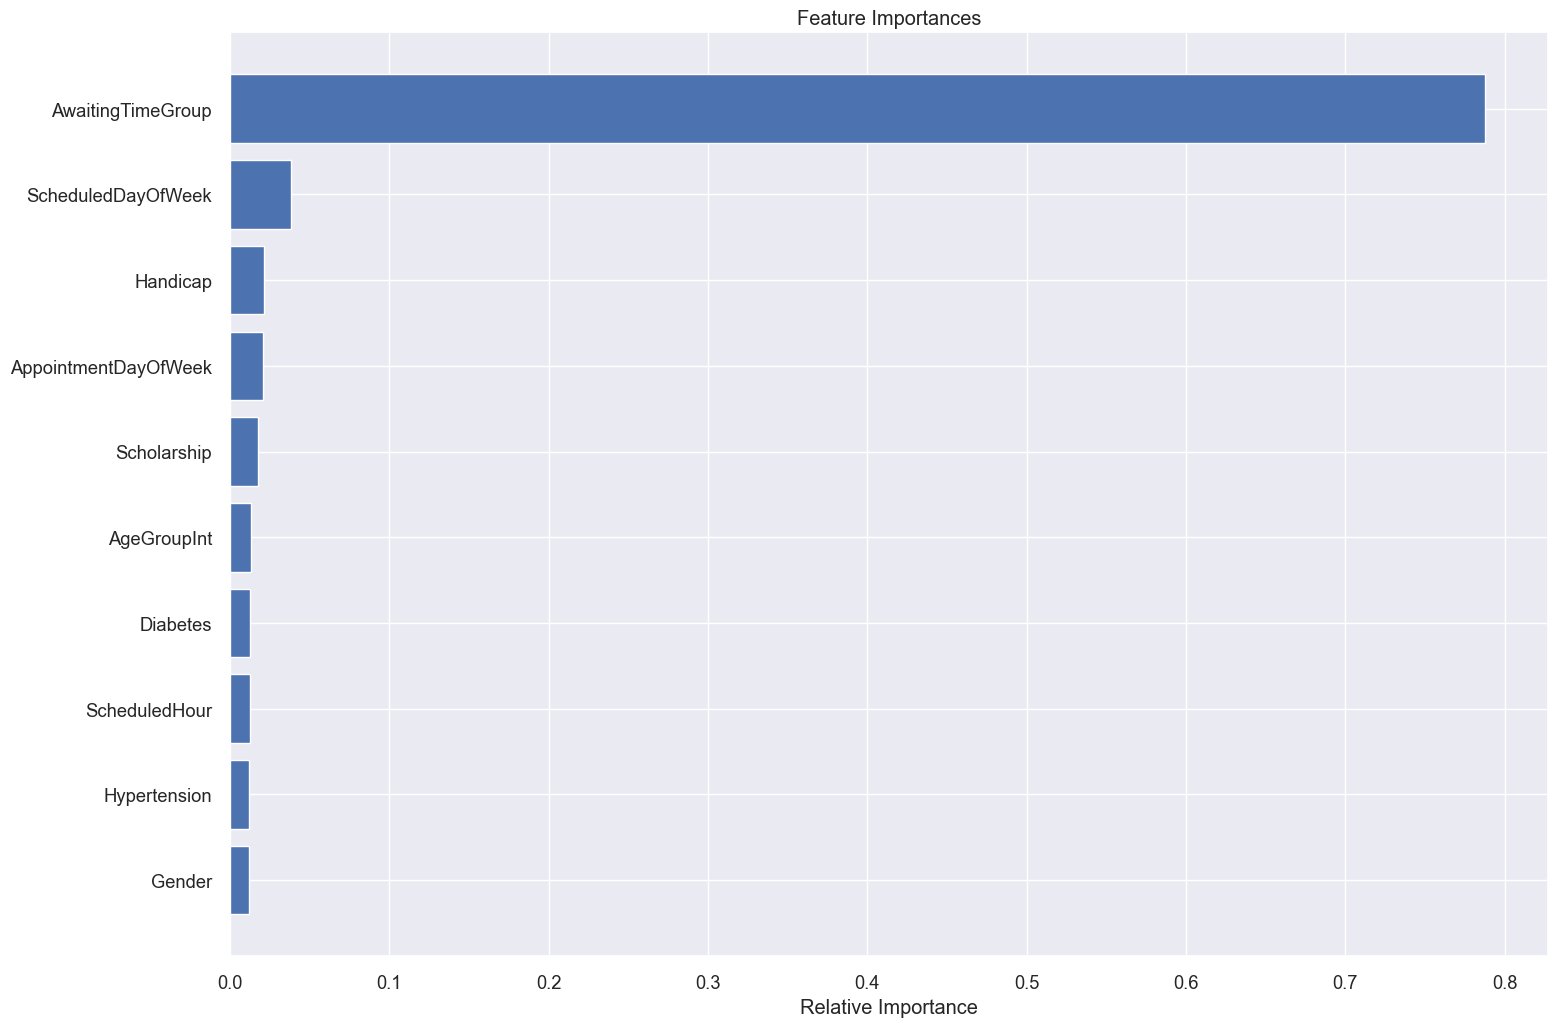

In [49]:
importances_xgboost = xgboost_cls.feature_importances_
plt.figure(figsize=(17, 12))
sns.set(font_scale=1.2)
indices = np.argsort(importances_xgboost)[-10:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances_xgboost[indices], color='b', align='center')
plt.yticks(range(len(indices)), X.columns[indices])
plt.xlabel('Relative Importance')
plt.show()

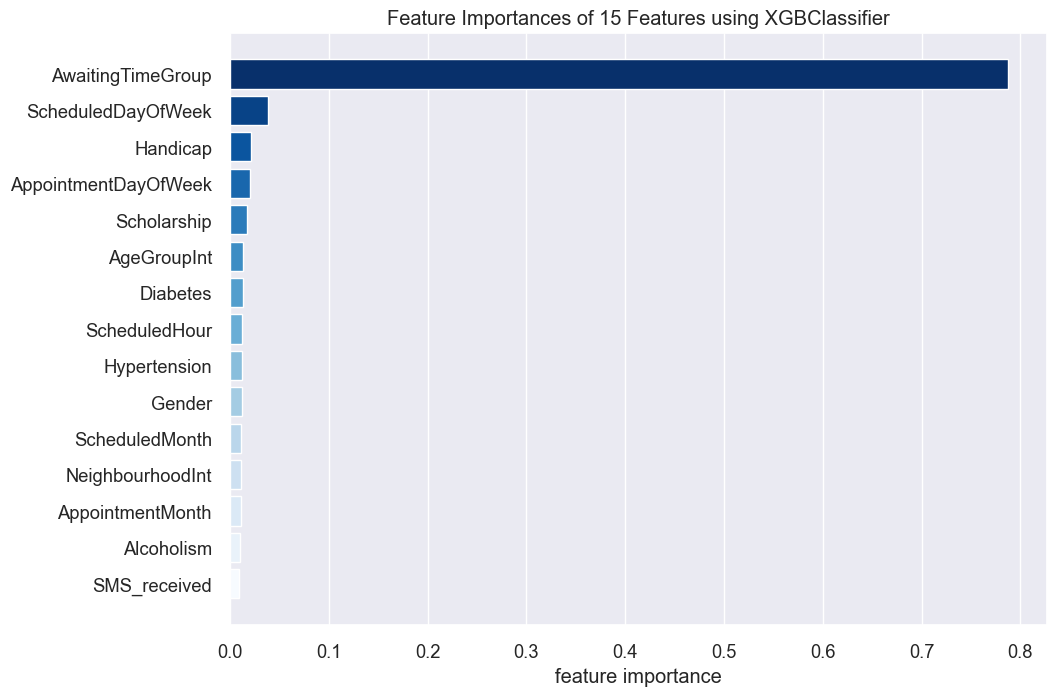

<Axes: title={'center': 'Feature Importances of 15 Features using XGBClassifier'}, xlabel='feature importance'>

In [37]:
viz = FeatureImportances(
    xgboost_cls,
    size=(1080, 720),
    max_num_features=10,
    relative=False,
    colormap='Blues',
)
viz.fit(X_train, y_train)
viz.show()

#### LIME

In [50]:
X_test.shape

(13389, 15)

In [51]:
lime = LimeTabular(
    model=xgboost_cls,
    data=X_train,
    random_state=1
)

lime_local = lime.explain_local(
    X_test[12990:13004],
    y_test[12990:13004],
    name='LIME'
)

show(lime_local)

<!-- http://127.0.0.1:7001/11637597952/ -->

In [69]:
X_test[12995:13004]

,Gender,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,ScheduledHour,ScheduledMonth,AppointmentMonth,AwaitingTimeDays,ScheduledDayOfWeek,AppointmentDayOfWeek,AgeGroupInt,NeighbourhoodInt
27770,0,0,0,0,0,0,0,12,5,5,0,0,0,0,62
24126,0,0,0,0,0,0,0,12,5,5,0,1,1,2,23
16109,1,0,1,1,0,0,0,14,5,5,5,4,2,3,12
9936,1,0,0,0,0,0,0,7,5,5,2,2,4,2,6
15390,0,0,0,0,0,0,0,8,5,5,13,1,0,2,22
4227,1,0,0,0,0,0,0,10,5,5,19,3,1,2,3
19756,1,0,0,0,0,0,1,15,5,6,21,0,0,2,40
15130,0,0,0,0,0,0,0,13,5,5,0,3,3,3,41
21275,0,0,0,0,0,0,1,9,5,6,23,0,2,0,31


#### SHAP

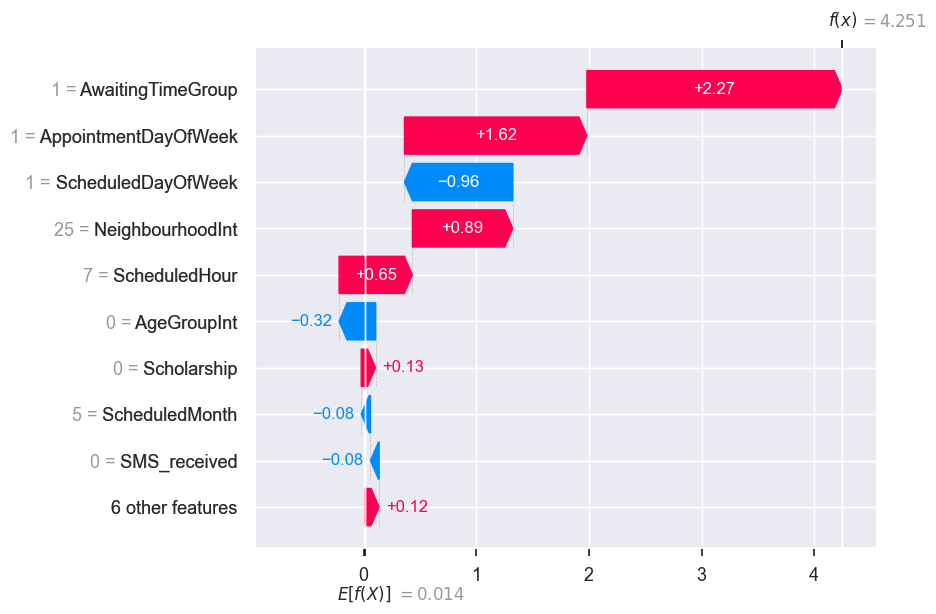

In [52]:
explainer = shap.Explainer(xgboost_cls)
shap_values = explainer(X_test)

shap.plots.waterfall(shap_values[12995])

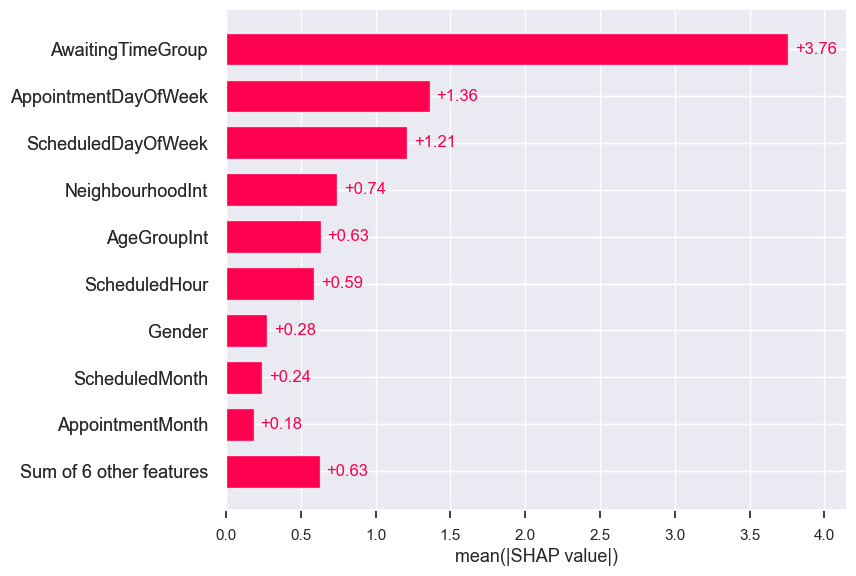

In [53]:
shap.plots.bar(shap_values)

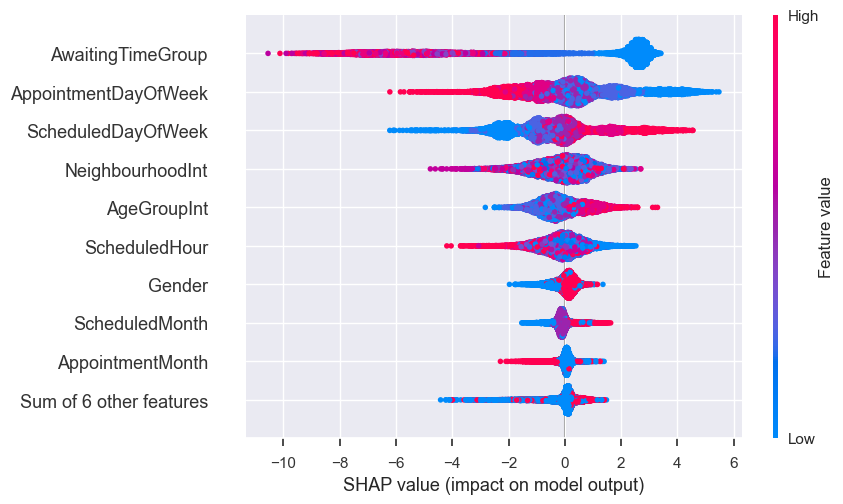

In [54]:
shap.plots.beeswarm(shap_values)

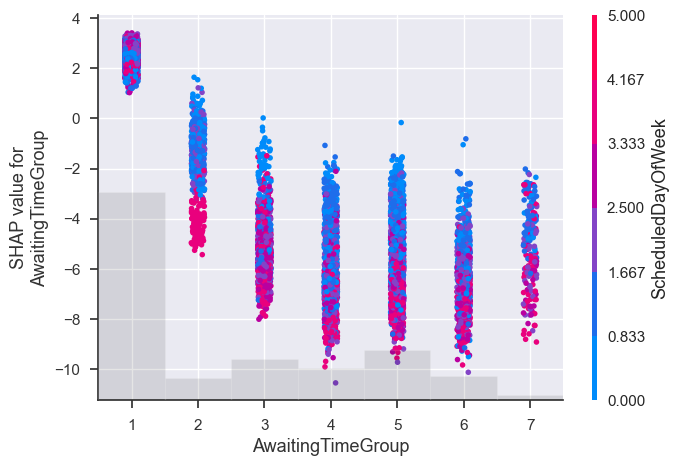

In [55]:
shap.plots.scatter(shap_values[:, "AwaitingTimeGroup"], color=shap_values)

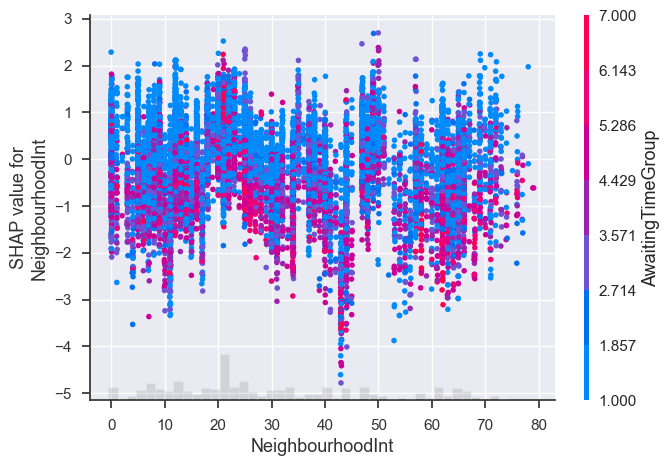

In [56]:
shap.plots.scatter(shap_values[:, "NeighbourhoodInt"], color=shap_values)

In [25]:
shap.plots.force(shap_values)

### 🌳 🌴 Random Forest

#### Hyperparameter tuning

In [27]:
config = {
    "name": "Random Forest",
    "method": "bayes",
    "metric": {
        "name": "accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "n_estimators": {
            "values": [10, 50, 100, 150, 200]
        },
        "criterion": {
            "values": ["gini", "entropy", "log_loss"],
        },
        "min_samples_split": {
            "values": [2, 4, 6]
        },
        "min_samples_leaf": {
            "values": [1, 2, 3]
        },
    }
}

In [28]:
def train():
    wandb.init(project=WANDB_PROJECT_NAME, config=wandb.config)

    config = wandb.config

    model = RandomForestClassifier(
        n_estimators=config.n_estimators,
        criterion=config.criterion,
        max_depth=None,
        min_samples_split=config.min_samples_split,
        min_samples_leaf=config.min_samples_leaf,
        max_features='auto',
        verbose=0,
        random_state=42,
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')

    wandb.log({"accuracy": accuracy, "f1": f1})
    wandb.log({"recall": recall, "precision": precision})

In [29]:
sweep_id = wandb.sweep(config, project=WANDB_PROJECT_NAME)
wandb.agent(sweep_id, function=train, count=15)

Create sweep with ID: sn46ukqd
Sweep URL: https://wandb.ai/polejowska/mappshow-hp-optimize/sweeps/sn46ukqd


wandb: Agent Starting Run: w3dbneqb with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95623
f1,0.95612
precision,0.95702
recall,0.95565


wandb: Agent Starting Run: a89r8nq8 with config:
wandb: 	criterion: entropy
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.9543
f1,0.95418
precision,0.95517
recall,0.95368


wandb: Agent Starting Run: jjdx2pr0 with config:
wandb: 	criterion: entropy
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.9513
f1,0.95117
precision,0.95222
recall,0.95066


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 11e8boqj with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95623
f1,0.95612
precision,0.95702
recall,0.95565


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wce6hqro with config:
wandb: 	criterion: entropy
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95444
f1,0.95433
precision,0.95532
recall,0.95383


wandb: Agent Starting Run: itj4nvya with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95623
f1,0.95612
precision,0.95702
recall,0.95565


wandb: Agent Starting Run: lxbn6j9z with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95623
f1,0.95612
precision,0.95702
recall,0.95565


wandb: Agent Starting Run: kxx3qu9o with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95623
f1,0.95612
precision,0.95702
recall,0.95565


wandb: Agent Starting Run: mfg1n9z8 with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95623
f1,0.95612
precision,0.95702
recall,0.95565


wandb: Agent Starting Run: ut40fzyd with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95623
f1,0.95612
precision,0.95702
recall,0.95565


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pfcx2u4n with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95623
f1,0.95612
precision,0.95702
recall,0.95565


wandb: Agent Starting Run: gjs5pspm with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95623
f1,0.95612
precision,0.95702
recall,0.95565


wandb: Agent Starting Run: bagvycyz with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95623
f1,0.95612
precision,0.95702
recall,0.95565


wandb: Agent Starting Run: hbvah6b1 with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95623
f1,0.95612
precision,0.95702
recall,0.95565


wandb: Agent Starting Run: jef0tur6 with config:
wandb: 	criterion: gini
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95623
f1,0.95612
precision,0.95702
recall,0.95565


In [30]:
wandb.finish()

#### Random Forest with the best hyperparameters training and evaluation

In [57]:
best_config = {
    "criterion": "gini",
    "min_samples_leaf": 1,
    "min_samples_split": 3,
    "n_estimators": 200,
}

rf_cls = RandomForestClassifier(
    n_estimators=best_config['n_estimators'],
    criterion=best_config['criterion'],
    max_depth=None,
    min_samples_split=best_config['min_samples_split'],
    min_samples_leaf=best_config['min_samples_leaf'],
    max_features='auto',
    verbose=0,
    random_state=42,
)

rf_cls.fit(X_train, y_train)

y_pred = rf_cls.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred, average='macro')

print('Accuracy: %.2f%%' % (accuracy_rf * 100.0))
print('F1 score: %.2f%%' % (f1_rf * 100.0))

Accuracy: 95.11%
F1 score: 95.11%


#### Feature importance

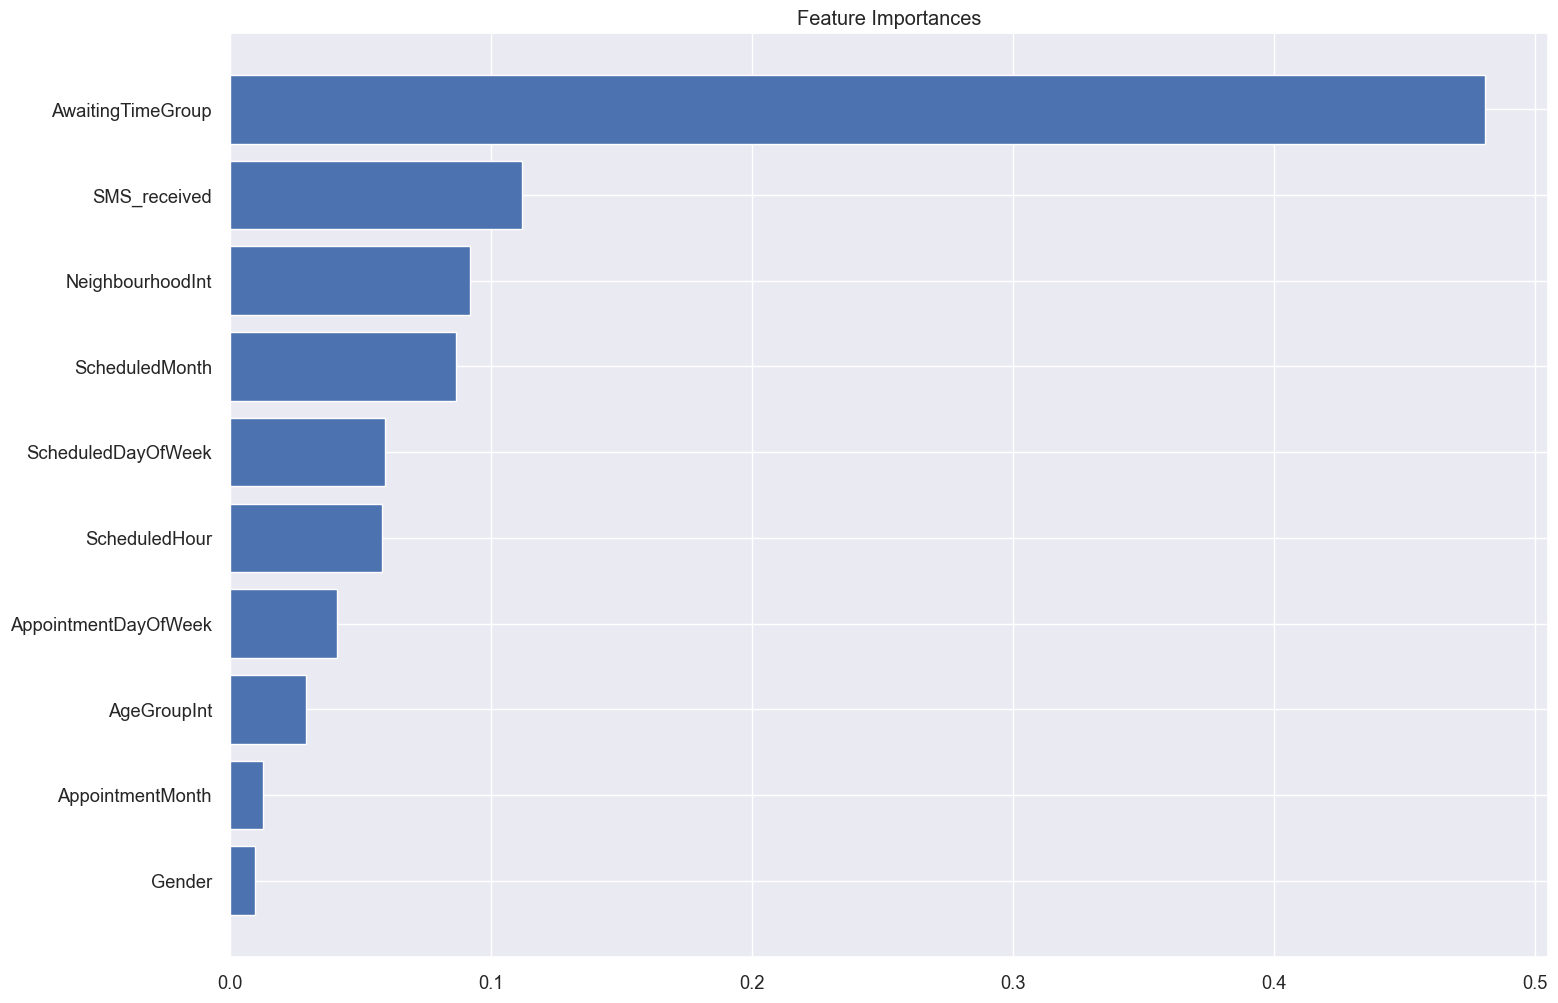

In [60]:
importances_rf = rf_cls.feature_importances_
# plot the feature importances and the feature names
plt.figure(figsize=(17, 12))
sns.set(font_scale=1.2)
# limit to ten features
indices = np.argsort(importances_rf)[-10:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances_rf[indices], color='b', align='center')
plt.yticks(range(len(indices)), X.columns[indices])
plt.show()

#### LIME 

In [26]:
X_test.shape

(14005, 15)

In [62]:
lime = LimeTabular(
    model=rf_cls,
    data=X_train,
    random_state=1
)

lime_local = lime.explain_local(
    X_test[1400:1402],
    y_test[1400:1402],
    name='LIME'
)

show(lime_local)

<!-- http://127.0.0.1:7001/11371686400/ -->

#### SHAP

In [64]:
explainer = shap.Explainer(rf_cls)
shap_values = explainer(X_test)

In [ ]:
shap.plots.bar(shap_values)

### 💥 Gradient Boosting

#### Hyperparameter tuning

In [28]:
gb_config = {
    "name": "Gradient Boosting",
    "method": "bayes",
    "metric": {
        "name": "accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "n_estimators": {
            "values": [10, 50, 100, 150, 200]
        },
        "learning_rate": {
            "values": [0.001, 0.01, 0.1, 1.0]
        },
        "loss": {
            "values": ["log_loss", "deviance", "exponential"]
        },
        "criterion": {
            "values": ["friedman_mse", "squared_error"]
        },
        "min_samples_leaf": {
            "values": [1, 2, 3]
        },
        "min_samples_split": {
            "values": [2, 4, 6]
        },
    }
}

def train_gb():
    wandb.init(project=WANDB_PROJECT_NAME, config=wandb.config)

    config = wandb.config

    model = GradientBoostingClassifier(
        n_estimators=config.n_estimators,
        learning_rate=config.learning_rate,
        max_depth=None,
        loss=config.loss,
        criterion=config.criterion,
        min_samples_leaf=config.min_samples_leaf,
        min_samples_split=config.min_samples_split,
        verbose=0,
        max_features='auto',
        random_state=42,
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')

    wandb.log({"accuracy": accuracy, "f1": f1})
    wandb.log({"recall": recall, "precision": precision})

In [29]:
sweep_id_gb = wandb.sweep(gb_config, project=WANDB_PROJECT_NAME)
wandb.agent(sweep_id_gb, function=train_gb, count=25)

Create sweep with ID: 5kq9qcjc
Sweep URL: https://wandb.ai/polejowska/mappshow-hp-optimize/sweeps/5kq9qcjc


wandb: Agent Starting Run: 9tl39ypr with config:
wandb: 	criterion: squared_error
wandb: 	learning_rate: 0.1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 150
wandb: Currently logged in as: polejowska. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.9568
f1,0.95671
precision,0.95732
recall,0.95634


wandb: Agent Starting Run: hlti8jad with config:
wandb: 	criterion: squared_error
wandb: 	learning_rate: 1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.9583
f1,0.95821
precision,0.9588
recall,0.95786


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7exb6ocy with config:
wandb: 	criterion: squared_error
wandb: 	learning_rate: 0.1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95801
f1,0.95792
precision,0.95857
recall,0.95755


wandb: Agent Starting Run: hdlnzbl4 with config:
wandb: 	criterion: friedman_mse
wandb: 	learning_rate: 0.001
wandb: 	loss: exponential
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.93045
f1,0.93005
precision,0.9343
recall,0.92894


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xw2g3tde with config:
wandb: 	criterion: squared_error
wandb: 	learning_rate: 1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.9573
f1,0.95722
precision,0.95769
recall,0.95692


wandb: Agent Starting Run: fzurxy5n with config:
wandb: 	criterion: squared_error
wandb: 	learning_rate: 1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.9573
f1,0.95722
precision,0.95769
recall,0.95692


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1qqrd0uf with config:
wandb: 	criterion: squared_error
wandb: 	learning_rate: 1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95045
f1,0.95037
precision,0.95056
recall,0.95021


wandb: Agent Starting Run: 1jsijq6n with config:
wandb: 	criterion: squared_error
wandb: 	learning_rate: 1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95916
f1,0.95907
precision,0.95973
recall,0.95869


wandb: Agent Starting Run: s2s31u0o with config:
wandb: 	criterion: squared_error
wandb: 	learning_rate: 1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95594
f1,0.95585
precision,0.95641
recall,0.95552


wandb: Agent Starting Run: nlvs0p0m with config:
wandb: 	criterion: squared_error
wandb: 	learning_rate: 0.1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.9568
f1,0.95671
precision,0.95732
recall,0.95634


wandb: Agent Starting Run: 7hfyv9g7 with config:
wandb: 	criterion: squared_error
wandb: 	learning_rate: 1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95823
f1,0.95814
precision,0.95866
recall,0.95782


wandb: Agent Starting Run: zvb1kt98 with config:
wandb: 	criterion: squared_error
wandb: 	learning_rate: 1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95823
f1,0.95814
precision,0.95866
recall,0.95782


wandb: Agent Starting Run: ydcslrmf with config:
wandb: 	criterion: friedman_mse
wandb: 	learning_rate: 1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.9578
f1,0.95771
precision,0.95826
recall,0.95738


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iwjoueh6 with config:
wandb: 	criterion: squared_error
wandb: 	learning_rate: 1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95823
f1,0.95814
precision,0.95866
recall,0.95782


wandb: Agent Starting Run: j5kutmap with config:
wandb: 	criterion: squared_error
wandb: 	learning_rate: 1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95744
f1,0.95736
precision,0.95775
recall,0.95711


wandb: Agent Starting Run: 9mhwsbre with config:
wandb: 	criterion: squared_error
wandb: 	learning_rate: 1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.9573
f1,0.95722
precision,0.95769
recall,0.95692


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mje2bazo with config:
wandb: 	criterion: squared_error
wandb: 	learning_rate: 1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95823
f1,0.95814
precision,0.95866
recall,0.95782


wandb: Agent Starting Run: bpfko07s with config:
wandb: 	criterion: friedman_mse
wandb: 	learning_rate: 1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95637
f1,0.95629
precision,0.95664
recall,0.95606


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k02hr9zz with config:
wandb: 	criterion: squared_error
wandb: 	learning_rate: 1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95916
f1,0.95907
precision,0.95973
recall,0.95869


wandb: Agent Starting Run: hr1sk3gm with config:
wandb: 	criterion: squared_error
wandb: 	learning_rate: 1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95823
f1,0.95814
precision,0.95866
recall,0.95782


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qc7tjda7 with config:
wandb: 	criterion: squared_error
wandb: 	learning_rate: 1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95916
f1,0.95907
precision,0.95973
recall,0.95869


wandb: Agent Starting Run: 3fogj4kc with config:
wandb: 	criterion: squared_error
wandb: 	learning_rate: 1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95744
f1,0.95736
precision,0.95775
recall,0.95711


wandb: Agent Starting Run: t80vry10 with config:
wandb: 	criterion: squared_error
wandb: 	learning_rate: 1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95823
f1,0.95814
precision,0.95866
recall,0.95782


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w3c4vu49 with config:
wandb: 	criterion: friedman_mse
wandb: 	learning_rate: 1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.95702
f1,0.95693
precision,0.95744
recall,0.95661


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w1781n2x with config:
wandb: 	criterion: squared_error
wandb: 	learning_rate: 1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.9573
f1,0.95722
precision,0.95769
recall,0.95692


In [31]:
wandb.finish()

#### Gradient Boosting with the best hyperparameters training and evaluation

In [32]:
best_config_gb = {
    "criterion": "squared_error",
    "learning_rate": 1,
    "loss": "log_loss",
    "min_samples_leaf": 3,
    "min_samples_split": 6,
    "n_estimators": 50,
}

gb_cls = GradientBoostingClassifier(
    n_estimators=best_config_gb['n_estimators'],
    learning_rate=best_config_gb['learning_rate'],
    max_depth=None,
    loss=best_config_gb['loss'],
    criterion=best_config_gb['criterion'],
    min_samples_leaf=best_config_gb['min_samples_leaf'],
    min_samples_split=best_config_gb['min_samples_split'],
    verbose=0,
    max_features='auto',
    random_state=42,
)

gb_cls.fit(X_train, y_train)

y_pred = gb_cls.predict(X_test)

accuracy_gb = accuracy_score(y_test, y_pred)
f1_gb = f1_score(y_test, y_pred, average='macro')

print('Accuracy: %.2f%%' % (accuracy_gb * 100.0))
print('F1 score: %.2f%%' % (f1_gb * 100.0))

Accuracy: 95.92%
F1 score: 95.91%


#### Feature importance

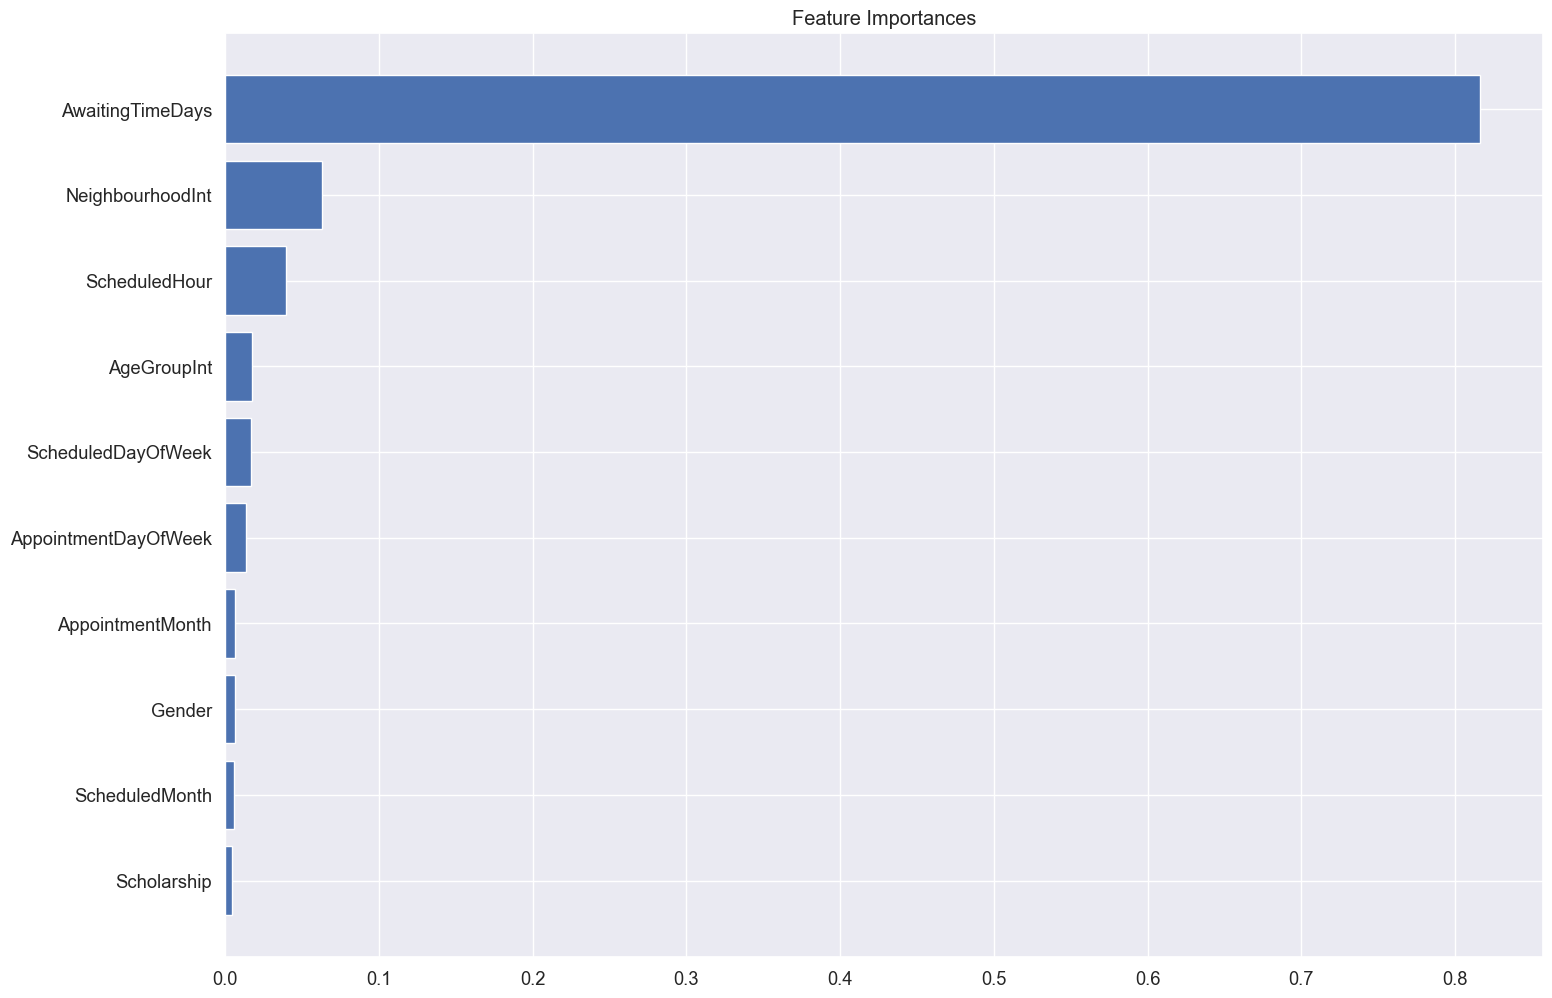

In [33]:
importances_gb = gb_cls.feature_importances_
plt.figure(figsize=(17, 12))
sns.set(font_scale=1.2)
indices = np.argsort(importances_gb)[-10:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances_gb[indices], color='b', align='center')
plt.yticks(range(len(indices)), X.columns[indices])
plt.show()

#### Partial Dependence Plots (PDPs)

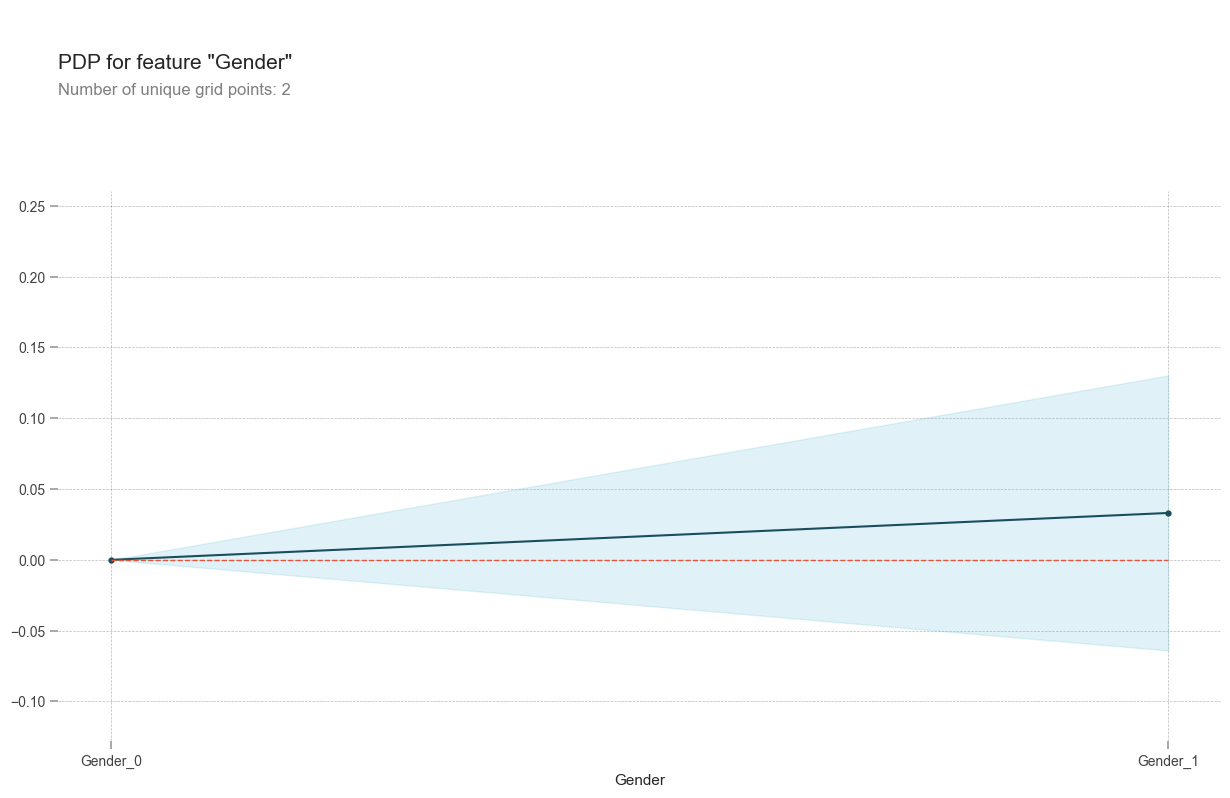

In [48]:
pdp_dist = pdp.pdp_isolate(model=gb_cls, dataset=X, model_features=X.columns, feature='Gender')
pdp.pdp_plot(pdp_dist, 'Gender')
plt.show()

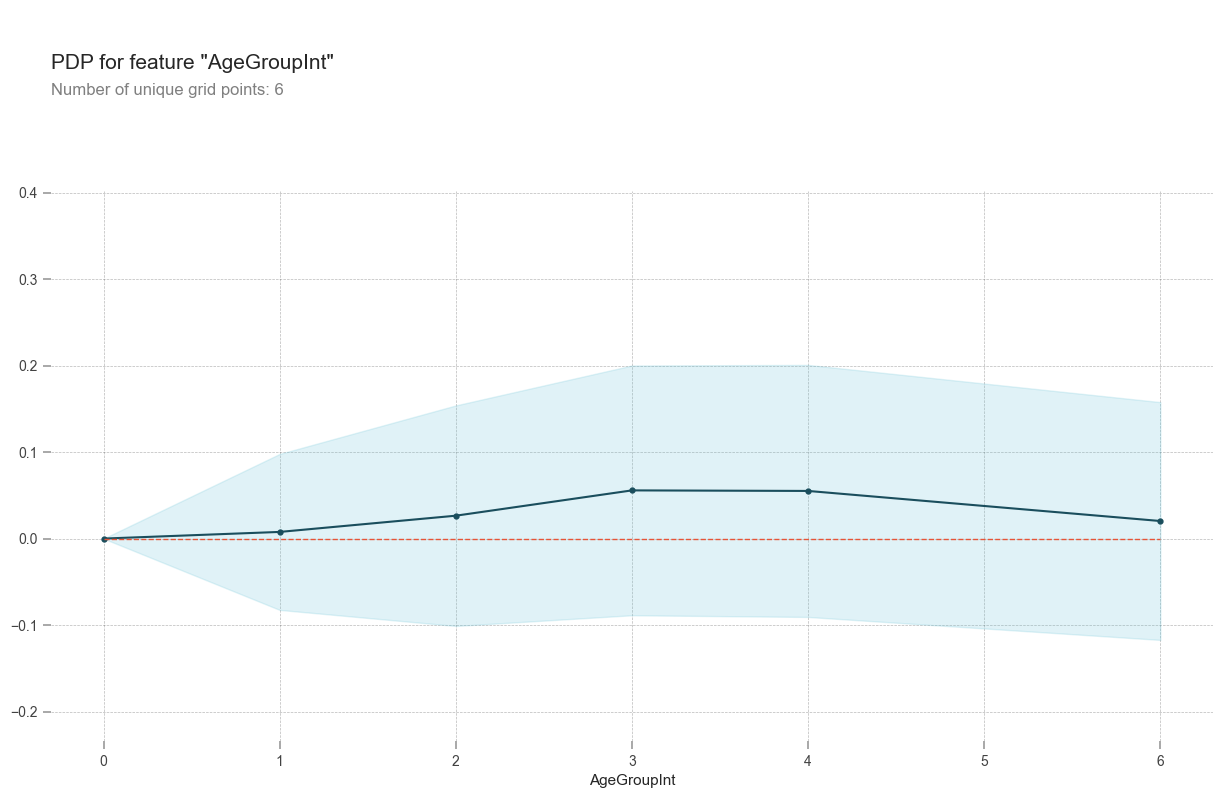

In [51]:
pdp_dist = pdp.pdp_isolate(model=gb_cls, dataset=X, model_features=X.columns, feature='AgeGroupInt')
pdp.pdp_plot(pdp_dist, 'AgeGroupInt')
plt.show()

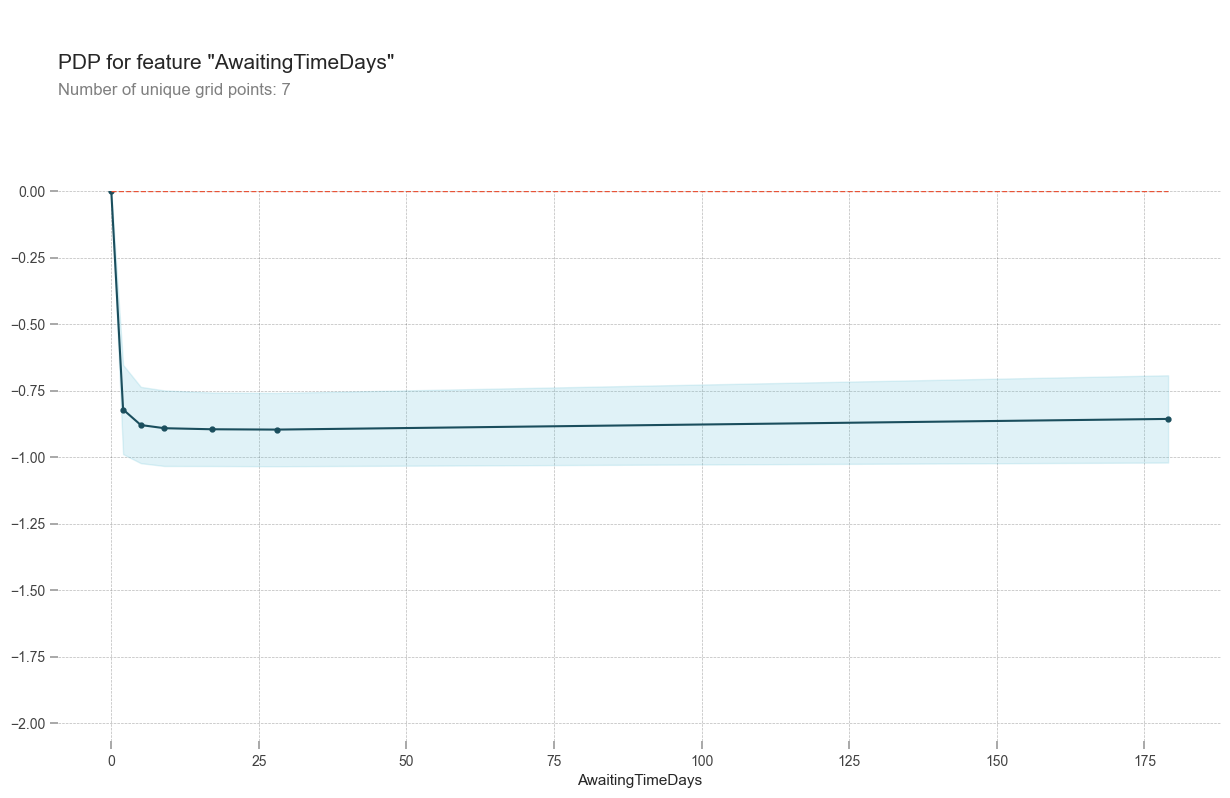

In [52]:
pdp_dist = pdp.pdp_isolate(model=gb_cls, dataset=X, model_features=X.columns, feature='AwaitingTimeDays')
pdp.pdp_plot(pdp_dist, 'AwaitingTimeDays')
plt.show()

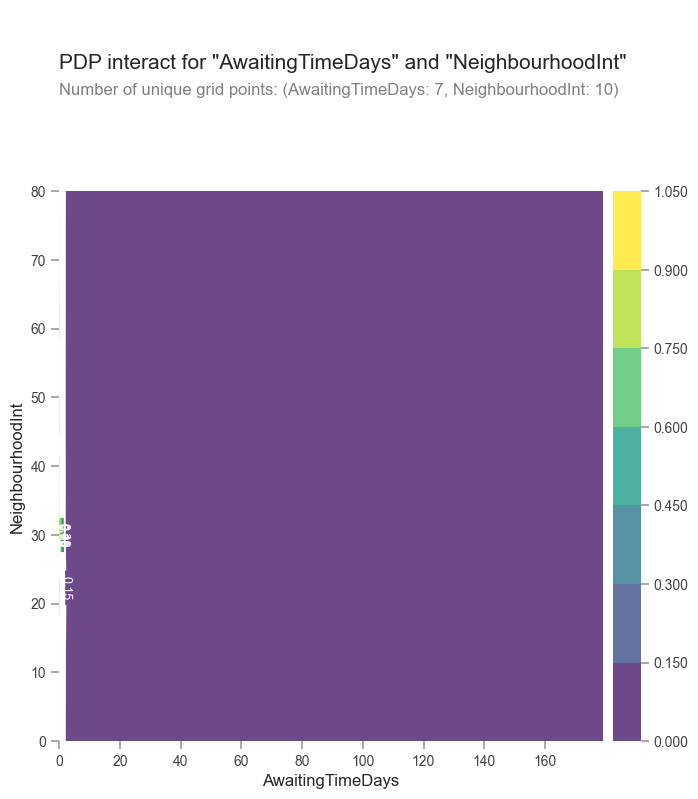

In [53]:
# pdp for feature combination (2 features, 'AwaitingTimeDays' and 'NeighbourhoodInt')
pdp_dist = pdp.pdp_interact(model=gb_cls, dataset=X, model_features=X.columns, features=['AwaitingTimeDays', 'NeighbourhoodInt'])
pdp.pdp_interact_plot(pdp_dist, ['AwaitingTimeDays', 'NeighbourhoodInt'], plot_type='contour')
plt.show()

#### LIME

In [46]:
lime = LimeTabular(
    model=gb_cls,
    data=X_train,
    random_state=1
)

lime_local = lime.explain_local(
    X_test[1400:1402],
    y_test[1400:1402],
    name='LIME'
)

show(lime_local) 

<!-- http://127.0.0.1:7001/12414060576/ -->

#### SHAP

In [ ]:
explainer = shap.Explainer(gb_cls)
shap_values = explainer(X_test)

shap.plots.bar(shap_values)

### ☄️ AdaBoost

#### Hyperparameter tuning

In [40]:
adaboost_sweep_config = {
    "name": "Adaboost",
    "method": "bayes",
    "metric": {
        "name": "accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "n_estimators": {
            "values": [10, 50, 100, 150, 200]
        },
        "learning_rate": {
            "values": [0.001, 0.01, 0.1, 1.0]   
        },
        "algorithm": {
            "values": ["SAMME", "SAMME.R"]
        },
    }
}


def train_adaboost():
    wandb.init(project=WANDB_PROJECT_NAME, config=wandb.config)

    config = wandb.config

    model = AdaBoostClassifier(
        n_estimators=config.n_estimators,
        learning_rate=config.learning_rate,
        algorithm=config.algorithm,
        random_state=42,
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')

    wandb.log({"accuracy": accuracy, "f1": f1})
    wandb.log({"recall": recall, "precision": precision})


sweep_id_adaboost = wandb.sweep(adaboost_sweep_config, project=WANDB_PROJECT_NAME)
wandb.agent(sweep_id_adaboost, function=train_adaboost, count=10)

Create sweep with ID: 7afyfe5k
Sweep URL: https://wandb.ai/polejowska/mappshow-hp-optimize/sweeps/7afyfe5k


wandb: Agent Starting Run: g3zmfost with config:
wandb: 	algorithm: SAMME.R
wandb: 	learning_rate: 1
wandb: 	n_estimators: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.94295
f1,0.94278
precision,0.94399
recall,0.94223


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a9kpoda0 with config:
wandb: 	algorithm: SAMME.R
wandb: 	learning_rate: 1
wandb: 	n_estimators: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.94295
f1,0.94278
precision,0.94399
recall,0.94223


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o7j3dlq3 with config:
wandb: 	algorithm: SAMME
wandb: 	learning_rate: 0.01
wandb: 	n_estimators: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.94295
f1,0.94278
precision,0.94399
recall,0.94223


wandb: Agent Starting Run: bp3xj9dy with config:
wandb: 	algorithm: SAMME.R
wandb: 	learning_rate: 0.001
wandb: 	n_estimators: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.94295
f1,0.94278
precision,0.94399
recall,0.94223


wandb: Agent Starting Run: uvdn549b with config:
wandb: 	algorithm: SAMME
wandb: 	learning_rate: 1
wandb: 	n_estimators: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.94295
f1,0.94278
precision,0.94399
recall,0.94223


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mfmagup0 with config:
wandb: 	algorithm: SAMME
wandb: 	learning_rate: 0.01
wandb: 	n_estimators: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.94295
f1,0.94278
precision,0.94399
recall,0.94223


wandb: Agent Starting Run: d5k5x7mc with config:
wandb: 	algorithm: SAMME.R
wandb: 	learning_rate: 0.01
wandb: 	n_estimators: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.94295
f1,0.94278
precision,0.94399
recall,0.94223


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 41l7bcu0 with config:
wandb: 	algorithm: SAMME.R
wandb: 	learning_rate: 0.01
wandb: 	n_estimators: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.94295
f1,0.94278
precision,0.94399
recall,0.94223


wandb: Agent Starting Run: jdyz5vtr with config:
wandb: 	algorithm: SAMME
wandb: 	learning_rate: 0.1
wandb: 	n_estimators: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.94295
f1,0.94278
precision,0.94399
recall,0.94223


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: at398dor with config:
wandb: 	algorithm: SAMME
wandb: 	learning_rate: 0.01
wandb: 	n_estimators: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.94295
f1,0.94278
precision,0.94399
recall,0.94223


#### AdaBoost with the best hyperparameters training and evaluation

In [41]:
best_config_adaboost = {
    "algorithm": "SAMME.R",
    "learning_rate": 0.1,
    "n_estimators": 50,
}


adaboost_cls = AdaBoostClassifier(
    n_estimators=best_config_adaboost['n_estimators'],
    learning_rate=best_config_adaboost['learning_rate'],
    algorithm=best_config_adaboost['algorithm'],
    random_state=42,
)

adaboost_cls.fit(X_train, y_train)

y_pred = adaboost_cls.predict(X_test)

accuracy_adaboost = accuracy_score(y_test, y_pred)
f1_adaboost = f1_score(y_test, y_pred, average='macro')

print('Accuracy: %.2f%%' % (accuracy_adaboost * 100.0))
print('F1 score: %.2f%%' % (f1_adaboost * 100.0))

Accuracy: 94.29%
F1 score: 94.28%


#### Feature importance

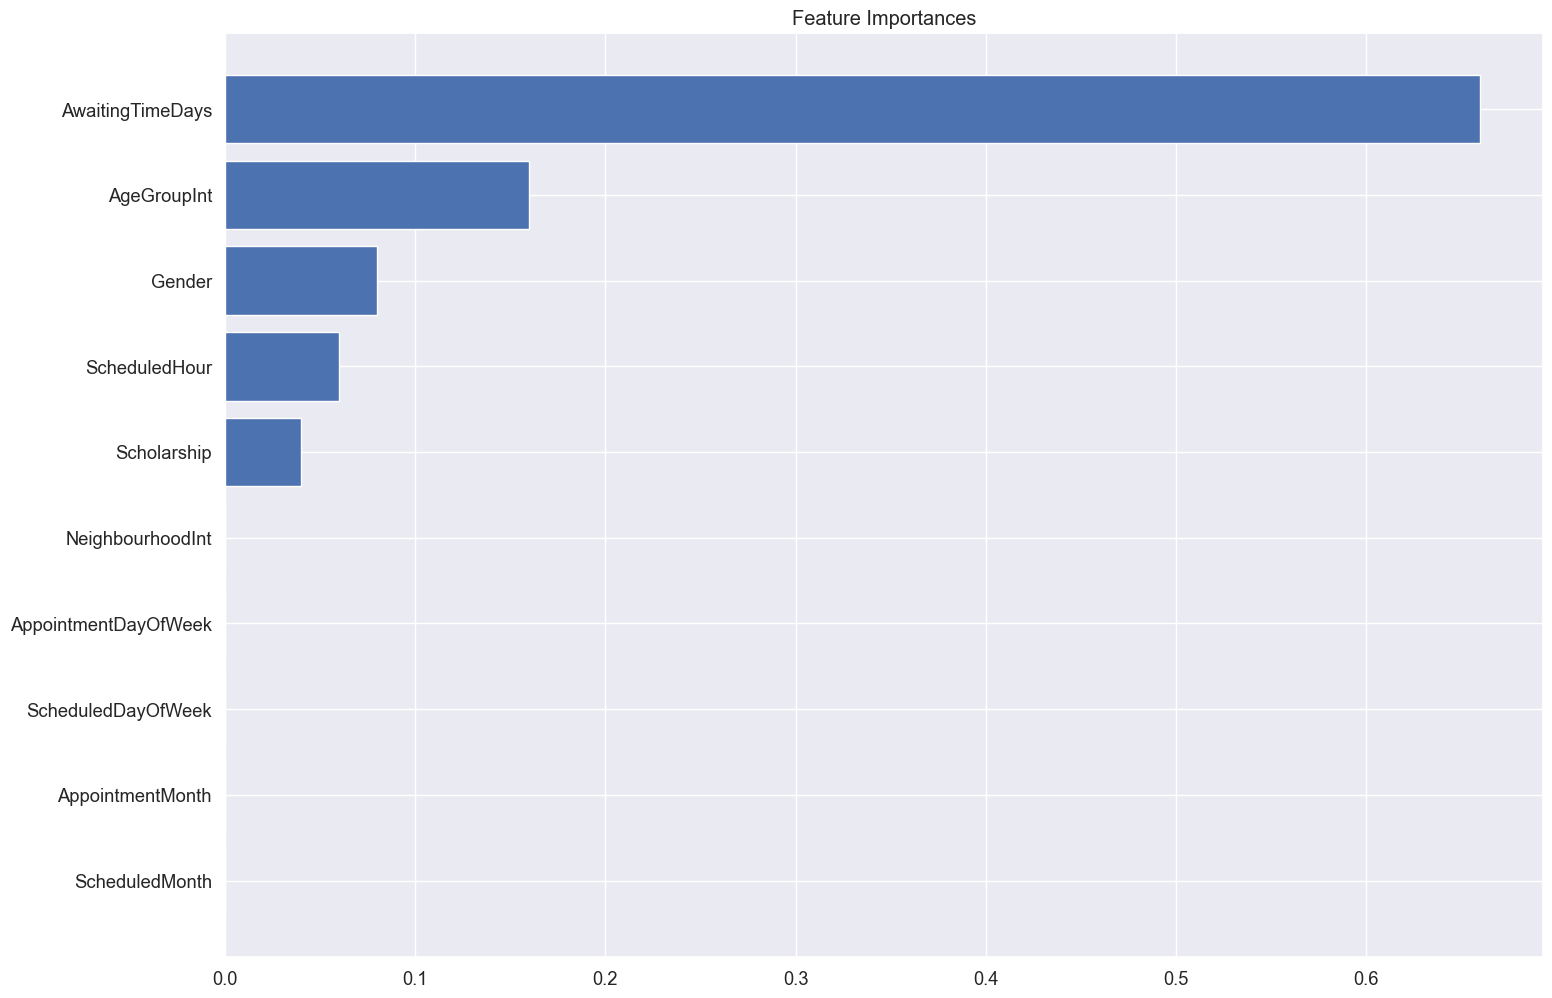

In [42]:
importances_ada = adaboost_cls.feature_importances_
plt.figure(figsize=(17, 12))
sns.set(font_scale=1.2)
indices = np.argsort(importances_ada)[-10:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances_ada[indices], color='b', align='center')
plt.yticks(range(len(indices)), X.columns[indices])
plt.show()

#### LIME

In [45]:
lime = LimeTabular(
    model=adaboost_cls,
    data=X_train,
    random_state=1
)

lime_local = lime.explain_local(
    X_test[1400:1402],
    y_test[1400:1402],
    name='LIME'
)

show(lime_local)  

<!-- http://127.0.0.1:7001/12400598944/ -->

#### SHAP

In [ ]:
explainer = shap.Explainer(adaboost_cls)
shap_values = explainer(X_test)

shap.plots.bar(shap_values)